In [1]:
import sympy as sp
sp.init_printing()
from functools import reduce

import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

from nbsupport import md

sp.var('a n x')
pass

In [2]:
md(r'# Newton-Raphson法を用いた$\sqrt a$の求解')

md(r'''正数$a$の平方根を数値的に求める標準解法は
方程式$f(x) = x^2 - a = 0$へのNewton-Raphson法の適用です．
この手法では，解$x$の近似解$x_n$の近似度を漸次改善します．
このために関数$f$の$(x_n, f(x_n))$周辺におけるTaylor展開の一次近似
$x_n - f(x_n) / f'(x_n)$を用います．$f$の定義をこれにあてはめて
\begin{align}
f(x)    &= x^2 - a \\
f'(x)   &= 2x \\
x_{n+1} &= x_n - \frac {f(x_n)}{f'(x_n)}
         = x_n - \frac {x_n^2 - a} {2x_n}
         = \frac {x + a / x} 2
\end{align}が得られます．''')

def sqrt(a):
    x = 1
    for i in range(5):
        x = (x + a / x) / 2
    return x

md(r'$\sqrt 2 \sim x_5 = ', sqrt(2), '$')

# Newton-Raphson法を用いた$\sqrt a$の求解

正数$a$の平方根を数値的に求める標準解法は
方程式$f(x) = x^2 - a = 0$へのNewton-Raphson法の適用です．
この手法では，解$x$の近似解$x_n$の近似度を漸次改善します．
このために関数$f$の$(x_n, f(x_n))$周辺におけるTaylor展開の一次近似
$x_n - f(x_n) / f'(x_n)$を用います．$f$の定義をこれにあてはめて
\begin{align}
f(x)    &= x^2 - a \\
f'(x)   &= 2x \\
x_{n+1} &= x_n - \frac {f(x_n)}{f'(x_n)}
         = x_n - \frac {x_n^2 - a} {2x_n}
         = \frac {x + a / x} 2
\end{align}が得られます．

$\sqrt 2 \sim x_5 = 1.414213562373095$

一応、上のようにして2の平方根を求めることはできましたが、このプログラムについてはいくつか不満な点があります。

1. 2の平方根は定義から「$x^2 - 2 = 0$」という方程式の解として与えられます。でも、上で定義した`sqrt2`関数の定義のなかに現れる式`(x + 2 / x) / 2`はこの方程式とずいぶん異なる見かけです。このプログラムから、元々の方程式の姿を想像することは困難です。

1. 今度は、`sqrt2`のプログラムのドキュメントに目を向けると、元の式$f(x) = x^2 - 2$からプログラムで用いられている差分式$(x + 2/x)/x$を得る式変形が記述されています。プログラムの内容よりもドキュメントの方がはるかに複雑で、書くのも面倒なことがわかります。こんなドキュメント書いてられません。でも、前述のようにこのドキュメントなしにプログラムを解読することはほぼ不可能です。

1. 最後に、ドキュメントの一番最後に出現する式を見てみましょう。プログラムの式とほぼ同一です。同じ式を二回、しかも微妙に異なる書式（$\LaTeX$とPython）で書かされていることになり、冗長性があることがわかります。この例は簡単なので、ここで見える冗長性も許容範囲内かもしれませんが、適応対象の式が複雑化するにつれて、この冗長性は避けがたくなります。

以下では、以上、三つの問題点をSymPyを用いた数式処理、SymPyからPythonと$\LaTeX$コードの自動合成によって解決することを目指します。

In [3]:
def sqrt(a):
    X = sp.var('X')
    関数式 = X * X - a
    差分計算式 = X - 関数式 / sp.diff(関数式, X)
    差分計算   = sp.lambdify((X), 差分計算式)
    x = 1
    for i in range(5):
        x = 差分計算(x)
    return x

In [4]:
[sqrt(x) for x in [2, 3, 5, 7]]

In [5]:
md('# Newton-Raphsonの一般的な記述\n',
   'ここで定義する`NewtonRaphson`関数はSymPyの数式処理の仕組みを応用して',
   '数式に依存しない形式で記述したものです。')

def NewtonRaphson(関数式, x, *args):
    '''Generic implementation of
    Newton-Raphson method
    
    Args:
        関数式: Sympy形式の関数の式
    
        x: 関数式のうちの変数
    
    Returns:
        xに関する方程式「関数式 = 0」を求めるPythonのlambda'''    
    
    F = sp.Function('F')
    NEWTON_RAPHSON = x - F(x) / sp.diff(F(x), x)
    
    差分計算式 = NEWTON_RAPHSON.subs(F(x), 関数式).doit()
    差分計算   = sp.lambdify((x, *args), 差分計算式)

    関数      = sp.lambdify((x, *args), 関数式)
    
    def グラフ描画(X, Y, *args):
        minX, maxX, minY, maxY = np.min(X), np.max(X), np.min(Y), np.max(Y)
        mx, my = (maxX - minX) * 0.1, (maxY - minY) * 0.1
        plt.xlim(minX - mx, maxX + mx)
        plt.ylim(minY - my, maxY + my)
        
        FX = np.linspace(minX - mx, maxX + mx, 100, endpoint = True)
        plt.plot(FX, 関数(FX, *args))
        
        plt.plot(X, Y)
        
        ax = plt.gca()
        ax.spines['right'].set_color('none')
        ax.spines['left'].set_position(('data', X[len(X)-1]))

        ax.spines['top'].set_color('none')
        ax.spines['bottom'].set_position(('data', 0))
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
    
    def newton_raphson(*args, x = 1, ループ回数 = 5, 描画 = False):
        x0 = x
        X = [ x, x ]; Y = [ 0, 関数(x, *args) ]
        for i in range(ループ回数):
            x = 差分計算(x, *args)
            X.extend([x, x]); Y.extend([0, 関数(x, *args)])
        if 描画:
            md('-----\n\n## $', 関数式, '= 0$', 'の根の求解\n',
               'Newton-Raphson法を用いて $', 関数式, '= 0$ の根の解を $x=', x0,
               '$ から始めて逐次求解した様子の可視化。')
            グラフ描画(X, Y, *args)
        return x

    x_n, x_n1 = sp.var('x_n x_{n+1}')
    md('`NewtonRaphson`関数は、方程式 $', F(x), '=', 関数式,
       '''= 0$ の根をNewton-Raphson法を用いて求める関数を返します。
この手法は、方程式の根の近似値 $x_n$ を漸次改善します。
このために、$''', (x_n, F(x_n)), '''$ におけるTaylor展開の一次近似を用います：\n\n
$$''', NEWTON_RAPHSON, '$$\n\n',
'関数式の内容 $(', 関数式, ')$ をこれにあてはめて，以下の差分計算が得られます：\n\n$$',
x_n1, '=', 差分計算式.subs(x, x_n), '$$')
    
    return newton_raphson

# Newton-Raphsonの一般的な記述
ここで定義する`NewtonRaphson`関数はSymPyの数式処理の仕組みを応用して数式に依存しない形式で記述したものです。

In [6]:
md('# `NewtonRaphson`関数を用いた平方根の計算')

平方根 = NewtonRaphson(x**2 - a, x, a)
md(r'$\sqrt 2 = ', str(平方根(2)), '$')

# `NewtonRaphson`関数を用いた平方根の計算

`NewtonRaphson`関数は、方程式 $F{\left (x \right )}=- a + x^{2}= 0$ の根をNewton-Raphson法を用いて求める関数を返します。
この手法は、方程式の根の近似値 $x_n$ を漸次改善します。
このために、$\left ( x_{n}, \quad F{\left (x_{n} \right )}\right )$ におけるTaylor展開の一次近似を用います：


$$x - \frac{F{\left (x \right )}}{\frac{d}{d x} F{\left (x \right )}}$$

関数式の内容 $(- a + x^{2})$ をこれにあてはめて，以下の差分計算が得られます：

$$x_{{n+1}}=x_{n} - \frac{- a + x_{n}^{2}}{2 x_{n}}$$

$\sqrt 2 = 1.4142135623730951$

# $\sqrt[n]a$を求めるということは方程式 $x^n = a$を解くこと

`NewtonRaphson`関数は、方程式 $F{\left (x \right )}=- a + x^{n}= 0$ の根をNewton-Raphson法を用いて求める関数を返します。
この手法は、方程式の根の近似値 $x_n$ を漸次改善します。
このために、$\left ( x_{n}, \quad F{\left (x_{n} \right )}\right )$ におけるTaylor展開の一次近似を用います：


$$x - \frac{F{\left (x \right )}}{\frac{d}{d x} F{\left (x \right )}}$$

関数式の内容 $(- a + x^{n})$ をこれにあてはめて，以下の差分計算が得られます：

$$x_{{n+1}}=x_{n} - \frac{x_{n}}{n} x_{n}^{- n} \left(- a + x_{n}^{n}\right)$$

-----

## $- a + x^{n}= 0$の根の求解
Newton-Raphson法を用いて $- a + x^{n}= 0$ の根の解を $x=2$ から始めて逐次求解した様子の可視化。

$$1.4142135623730951^2=2.0000000000000004$$

-----

## $- a + x^{n}= 0$の根の求解
Newton-Raphson法を用いて $- a + x^{n}= 0$ の根の解を $x=2$ から始めて逐次求解した様子の可視化。

$$1.2599210498953948^3=2.000000000002484$$

-----

## $- a + x^{n}= 0$の根の求解
Newton-Raphson法を用いて $- a + x^{n}= 0$ の根の解を $x=2$ から始めて逐次求解した様子の可視化。

$$1.1892071900839556^4=2.0000005050843757$$

-----

## $- a + x^{n}= 0$の根の求解
Newton-Raphson法を用いて $- a + x^{n}= 0$ の根の解を $x=2$ から始めて逐次求解した様子の可視化。

$$1.1487382436984304^5=2.000347275432221$$

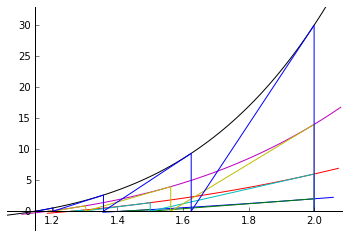

In [7]:
md('# $\sqrt[n]a$を求めるということは方程式 $x^n = a$を解くこと')

Ｎ乗根 = NewtonRaphson(x**n - a, x, a, n) # これだけ！

for i in range(2, 6):
    root = Ｎ乗根(2, i, x = 2, 描画 = True)
    md('$$', root, '^', i, '=', root ** i, r'$$')

# $\frac 1 {x^2} = \frac 1 a$ を用いて高速化

`NewtonRaphson`関数は、方程式 $F{\left (x \right )}=\frac{1}{x^{2}} - \frac{1}{a}= 0$ の根をNewton-Raphson法を用いて求める関数を返します。
この手法は、方程式の根の近似値 $x_n$ を漸次改善します。
このために、$\left ( x_{n}, \quad F{\left (x_{n} \right )}\right )$ におけるTaylor展開の一次近似を用います：


$$x - \frac{F{\left (x \right )}}{\frac{d}{d x} F{\left (x \right )}}$$

関数式の内容 $(\frac{1}{x^{2}} - \frac{1}{a})$ をこれにあてはめて，以下の差分計算が得られます：

$$x_{{n+1}}=\frac{x_{n}^{3}}{2} \left(\frac{1}{x_{n}^{2}} - \frac{1}{a}\right) + x_{n}$$

-----

## $\frac{1}{x^{2}} - \frac{1}{a}= 0$の根の求解
Newton-Raphson法を用いて $\frac{1}{x^{2}} - \frac{1}{a}= 0$ の根の解を $x=0.5$ から始めて逐次求解した様子の可視化。

\begin{align}\sqrt 2 & \sim 1.413183241547555\\\sqrt a & \sim \frac{1}{2} \left(1.5 - \frac{1}{2 a}\right)^{3} \left(\frac{1}{\left(1.5 - \frac{1}{2 a}\right)^{2}} - \frac{1}{a}\right) + \frac{1}{2} \left(\frac{1}{\left(\frac{1}{2} \left(1.5 - \frac{1}{2 a}\right)^{3} \left(\frac{1}{\left(1.5 - \frac{1}{2 a}\right)^{2}} - \frac{1}{a}\right) + 1.5 - \frac{1}{2 a}\right)^{2}} - \frac{1}{a}\right) \left(\frac{1}{2} \left(1.5 - \frac{1}{2 a}\right)^{3} \left(\frac{1}{\left(1.5 - \frac{1}{2 a}\right)^{2}} - \frac{1}{a}\right) + 1.5 - \frac{1}{2 a}\right)^{3} + 1.5 - \frac{1}{2 a}\end{align}

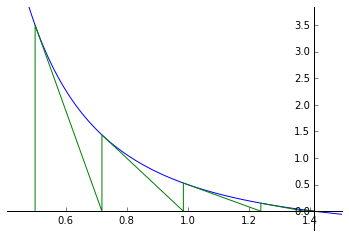

In [8]:
md(r'# $\frac 1 {x^2} = \frac 1 a$ を用いて高速化')

改善版平方根の計算 = NewtonRaphson(1/x**2 - 1/a, x, a)

md(r'\begin{align}',
     r'\sqrt 2 & \sim ', 改善版平方根の計算(2, x = .5, 描画 = True), r'\\',
     r'\sqrt a & \sim ', 改善版平方根の計算(a, ループ回数 = 3),
   r'\end{align}')